In [1]:
import numpy as np
import torch
import open_clip
import csv
from tqdm import tqdm
import pandas
import matplotlib.pyplot as plt

/home/martin/Documents/MScProject/project_local/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
testsets = {
    "Progan" : ["progan_lsun"],
    "Biggan" : ["biggan_256","biggan_512"],
    "Gaugan" : ["gaugan"],
    "Stargan" : ["stargan"],
    "EG3D" : ["eg3d"],
    "Stylegan 2": ["stylegan2_afhqv2_512x512",
                   "stylegan2_ffhq_256x256",
                   "stylegan2_ffhq_1024x1024",
                   "stylegan2_lsundog_256x256",
                   "whichfaceisreal"],
    "Stylegan 3" : ["stylegan3_r_afhqv2_512x512",
                    "stylegan3_r_ffhqu_256x256",
                    "stylegan3_r_ffhqu_1024x1024",
                    "stylegan3_t_afhqv2_512x512",
                    "stylegan3_t_ffhqu_256x256",
                    "stylegan3_t_ffhqu_1024x1024"],
    "Taming Trans." : ["taming-transformers_class2image_ImageNet",
                             "taming-transformers_noise2image_FFHQ",
                             "taming-transformers_segm2image_valid"],
    "Dall-E Mini" : ["dalle-mini_valid"],
    "Dall-E 2" : ["dalle_2"],
    "Glide" : ["glide_text2img_valid"],
    "Guided Dif." : ["guided-diffusion_class2image_ImageNet",  
                "guided-diffusion_noise2image_LSUNbedrooms",
                "guided-diffusion_noise2image_LSUNcats",
                "guided-diffusion_noise2image_LSUNhorses"],
    "Latent Dif." : ["latent-diffusion_class2image_ImageNet",
                          "latent-diffusion_noise2image_FFHQ",
                          "latent-diffusion_noise2image_LSUNbedrooms",
                          "latent-diffusion_noise2image_LSUNchurches",
                          "latent-diffusion_text2img_valid"],
    "Stable Diff." : ["stable_diffusion_256"],
    "Stable Diff. v2" : ["stable_diffusion_512_50steps",
                             "stable_diffusion_512_100steps",
                             "stable_diffusion_512_200steps"],
    "DeepFakes" : ["deepfake"],
    "Pristine" : ["real_coco_valid", 
                  "real_imagenet_val", 
                  "real_ucid",
                  "ffhq",
                  "celebA",
                  ],
}

In [3]:
def printAccuracyAtAllThresholds(tab, xline=None):
    thresholds = list(tab.columns)
    X = [float(t) for t in thresholds]
    plot_sets = list(testsets.keys())

    fig, ax = plt.subplots(layout='constrained')

    Y_real = []
    Y_fake = []
    Y_total = []
    for t in thresholds:
        measurement = []
        for set in plot_sets:
            subsets = testsets[set]
            m = np.mean([tab.loc[subset + '.pt', t] for subset in subsets])
            measurement.append(m)
        pristine_mean = measurement[-1]
        fake_mean = np.mean(measurement[:-1])
        total_mean = np.mean([(m+pristine_mean)/2 for m in measurement])
        print(t, ' : ', total_mean , '  ', (pristine_mean/fake_mean))
        Y_real.append(pristine_mean*100)
        Y_fake.append(fake_mean*100)
        Y_total.append(total_mean*100)

    # ax.set_ylabel("Accuracy")
    ax.set_xlabel("Treshold")
    ax.plot(X, Y_real, color='green', label="Real images")
    ax.plot(X, Y_fake, color='red', label="Fake images")
    ax.plot(X, Y_total, color='black', label="Average")
    if xline is not None:
        ax.axvline(xline, color='purple', linestyle='--')
        ax.text(xline + 0.01, 0, str(xline), color='purple')
    # ax.legend(loc='lower left')
    plt.show()



In [30]:
grag_accuracies = pandas.read_csv("data/grag_accuracies.csv", header=0, index_col=0)
vitL14_accuracies_openai_9NN = pandas.read_csv("data/progan-trained/vitL14_progan_openai_720k_9nn_accuracies.csv", header=0, index_col=0)
vitL14_accuracies_datacomp_net = pandas.read_csv("data/progan-trained/vitL14_progan_datacomp_720k_net_accuracies.csv", header=0, index_col=0)
vitH14_accuracies = pandas.read_csv("data/progan-trained/vitH14_progan_laion_100k_net_accuracies.csv", header=0, index_col=0)
vitL14_accuracies_openai_net = pandas.read_csv("data/progan-trained/vitL14_progan_openai_720k_net_accuracies.csv", header=0, index_col=0)

0.00  :  0.47058823529411764    0.0
0.05  :  0.733921783999592    0.6716336076458055
0.10  :  0.7513965159627614    0.7483692068953285
0.15  :  0.7602231004886065    0.7959034961722325
0.20  :  0.765965684687322    0.834003055862259
0.25  :  0.7707079960282921    0.8686958974803648
0.30  :  0.7738584998783268    0.8946940738563758
0.35  :  0.7774416275960947    0.9198585967572638
0.40  :  0.7793964108111415    0.9426995345635055
0.45  :  0.7826516547404827    0.967384694987866
0.50  :  0.7841253144460617    0.9899495242238201
0.55  :  0.7852629410950479    1.014832039949791
0.60  :  0.7866225351349634    1.0413771124604787
0.65  :  0.7889633799524719    1.0717233092066678
0.70  :  0.7911924843146082    1.1015847871171793
0.75  :  0.7934421958786867    1.1367989927478745
0.80  :  0.7938159128371839    1.1754518129521458
0.85  :  0.7938724906413316    1.224144603382365
0.90  :  0.7936262530125078    1.2970482206300933
0.95  :  0.7893700815876811    1.4209797901238361
1.00  :  0.565389768

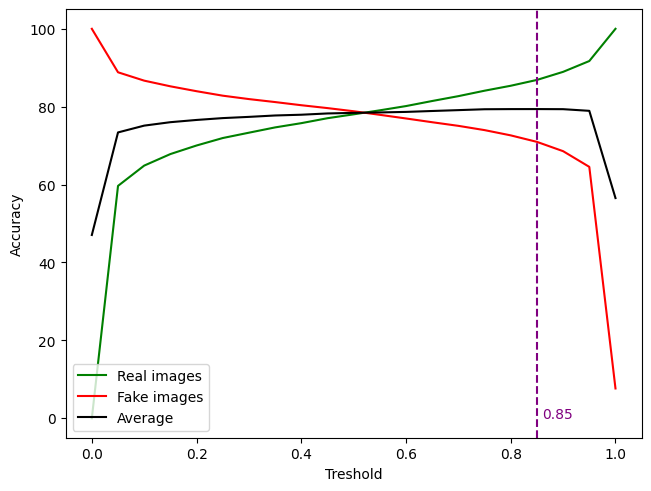

In [43]:
printAccuracyAtAllThresholds(vitL14_accuracies_datacomp_net, xline=0.85)

0.00  :  0.47058823529411764    0.0
0.05  :  0.7957830292619543    0.8789169906952514
0.10  :  0.8134818754155962    0.9775038074714788
0.15  :  0.8226421076110598    1.0448998167265033
0.20  :  0.8279706837792526    1.096594906075336
0.25  :  0.8308851269877239    1.1364336981946743
0.30  :  0.8320286161822078    1.1707784097928624
0.35  :  0.8319379688576999    1.1995088859771443
0.40  :  0.8314238043279031    1.2291457488481132
0.45  :  0.831446574166276    1.2569105588502525
0.50  :  0.8301856939028145    1.2876989964955368
0.55  :  0.8295599807807287    1.319985582259304
0.60  :  0.8285934663655673    1.345981197350016
0.65  :  0.827848965158689    1.3743690755471665
0.70  :  0.8243225614549486    1.4086817881719165
0.75  :  0.822426531939685    1.4436254128771333
0.80  :  0.8193742046527966    1.4898588783386622
0.85  :  0.8144881444693383    1.5459930617952622
0.90  :  0.8043598698756073    1.6260830491060023
0.95  :  0.7879926289872276    1.7576126271203454
1.00  :  0.551434554

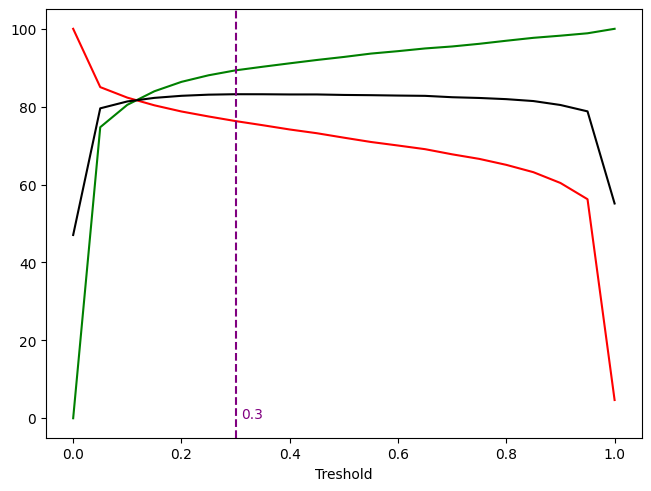

In [45]:
printAccuracyAtAllThresholds(vitL14_accuracies_openai_net, xline=0.30)

0.00  :  0.47058823529411764    0.0
0.05  :  0.6825999426674008    0.5112642473890497
0.10  :  0.7350450517418821    0.6706383598529726
0.15  :  0.7610927625945235    0.7732509896903977
0.20  :  0.7792272637714097    0.8541115762221482
0.25  :  0.7890443247139816    0.9193706703036117
0.30  :  0.7972477278092618    0.9828434913717685
0.35  :  0.8006832605464012    1.0385323835965041
0.40  :  0.8015715808767078    1.090026321400092
0.45  :  0.8039203000934124    1.1466740706289202
0.50  :  0.80434035134335    1.1992556610263811
0.55  :  0.8032403489101319    1.2566421291228365
0.60  :  0.8014162437938    1.3180365403292704
0.65  :  0.7989097767304051    1.3792388535975408
0.70  :  0.7951026714059056    1.4439041084629742
0.75  :  0.7891327012996369    1.5226501631068923
0.80  :  0.7801892964864647    1.6196407931237986
0.85  :  0.7691091247432799    1.750672192786641
0.90  :  0.7529940684892721    1.9380775902327496
0.95  :  0.7269829350023843    2.2850176203882224
1.00  :  0.5295588235

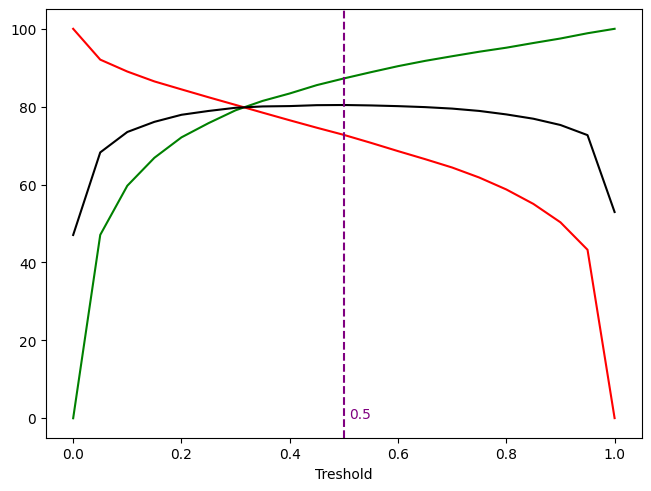

In [46]:
printAccuracyAtAllThresholds(vitH14_accuracies, xline=0.50)

In [4]:
vitL14_accuracies_datacomp_stable = pandas.read_csv("data/stable-trained/vitL14_stable_100k_datacomp_net_accuracies.csv", header=0, index_col=0)
vitH14_accuracies_laion_stable = pandas.read_csv("data/stable-trained/vitH14_stable_100k_laion_net_accuracies.csv", header=0, index_col=0)
vitL14_accuracies_openai_stable = pandas.read_csv("data/stable-trained/vitL14_stable_100k_openai_net_accuracies.csv", header=0, index_col=0)

0.00  :  0.47058823529411764    0.0
0.05  :  0.5293632505332678    0.16161508384295423
0.10  :  0.5568491383851417    0.24353934679873337
0.15  :  0.5755617899596961    0.30606435182900527
0.20  :  0.589727210568417    0.35882585281538143
0.25  :  0.60113104534672    0.4060130976349955
0.30  :  0.6105066407235479    0.448450921618093
0.35  :  0.6192886180987184    0.49134142914250856
0.40  :  0.6263562818202912    0.5319685032735469
0.45  :  0.6290626196289894    0.5664214108091707
0.50  :  0.6347744694417852    0.6072423085053488
0.55  :  0.640125549019813    0.6510383300341784
0.60  :  0.6428862185973302    0.6922763944999762
0.65  :  0.6457923650519911    0.7393408260427469
0.70  :  0.6484290814936164    0.7915434091250338
0.75  :  0.6509315924156543    0.8530309988572333
0.80  :  0.6523239115758263    0.9217236264725664
0.85  :  0.6526569175849759    1.0147681816580234
0.90  :  0.6535537383072776    1.1593409837991324
0.95  :  0.6451689393346496    1.4351143900269343
1.00  :  0.529

/tmp/ipykernel_61922/4035806803.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  print(t, ' : ', total_mean , '  ', (pristine_mean/fake_mean))


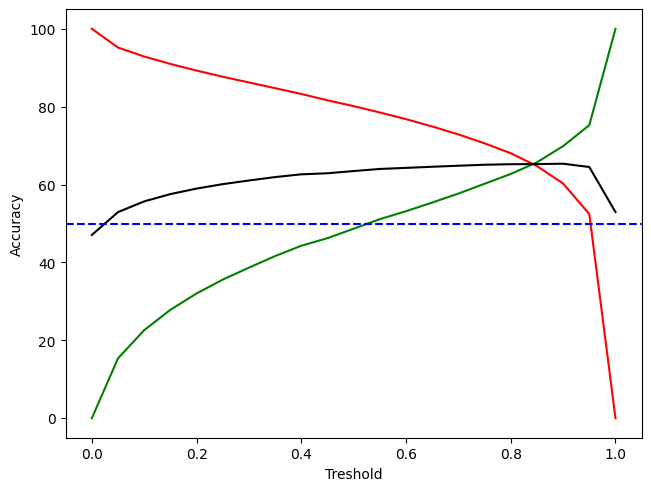

In [5]:
printAccuracyAtAllThresholds(vitL14_accuracies_datacomp_stable)

0.00  :  0.47058823529411764    0.0
0.05  :  0.7633670094902272    0.8316165570689261
0.10  :  0.7778200733326565    1.027780736157287
0.15  :  0.7751912202747203    1.1667765626018138
0.20  :  0.7714271091676614    1.2866524021068055
0.25  :  0.764793485769706    1.3917052285293554
0.30  :  0.7578105255451809    1.4940301808174485
0.35  :  0.7499167731135445    1.6031417647848385
0.40  :  0.7410767982069716    1.713745289947413
0.45  :  0.7320010586812632    1.8328455398401526
0.50  :  0.7227818108803582    1.9540865533502587
0.55  :  0.7137344253956902    2.094766821184663
0.60  :  0.7041319379931993    2.244982740359681
0.65  :  0.6933213587401489    2.421029890567639
0.70  :  0.6835532199802588    2.631313620306368
0.75  :  0.6705409996430078    2.904744230988928
0.80  :  0.657449799244735    3.2464507328201075
0.85  :  0.6422199093724706    3.746552988510967
0.90  :  0.6229999006322143    4.588035813851021
0.95  :  0.5960483324723151    6.623895241687483
1.00  :  0.529411764705882

/tmp/ipykernel_23801/4035806803.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  print(t, ' : ', total_mean , '  ', (pristine_mean/fake_mean))


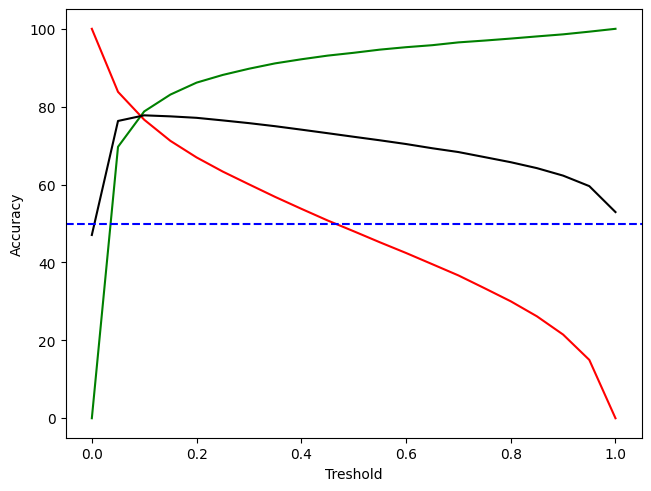

In [18]:
printAccuracyAtAllThresholds(vitL14_accuracies_openai_stable)

0.00  :  0.47058823529411764    0.0
0.05  :  0.6141201605329397    0.3753569776933662
0.10  :  0.6370783029774233    0.48319285007053375
0.15  :  0.6509904232553382    0.5650079155403083
0.20  :  0.6579994095001458    0.6309671223396138
0.25  :  0.6648415631091014    0.6956196678284833
0.30  :  0.6685114106511431    0.7517144733633142
0.35  :  0.6728762325783768    0.8154220798376954
0.40  :  0.6748241326915224    0.8732382550087201
0.45  :  0.6767610735572235    0.9352697906461921
0.50  :  0.6761205136940254    0.9989183849261923
0.55  :  0.6769416064680028    1.0710106105978683
0.60  :  0.6740366623661478    1.14339818136243
0.65  :  0.675123672265272    1.2354086052101698
0.70  :  0.6724191638055654    1.342033955860991
0.75  :  0.6695810765437085    1.46546562723044
0.80  :  0.6660939885199001    1.620375750560852
0.85  :  0.6609629137459528    1.8355855108708734
0.90  :  0.6515528406025943    2.1953869318707184
0.95  :  0.6302680106939871    2.9802015332024427
1.00  :  0.529411764

/tmp/ipykernel_23801/4035806803.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  print(t, ' : ', total_mean , '  ', (pristine_mean/fake_mean))


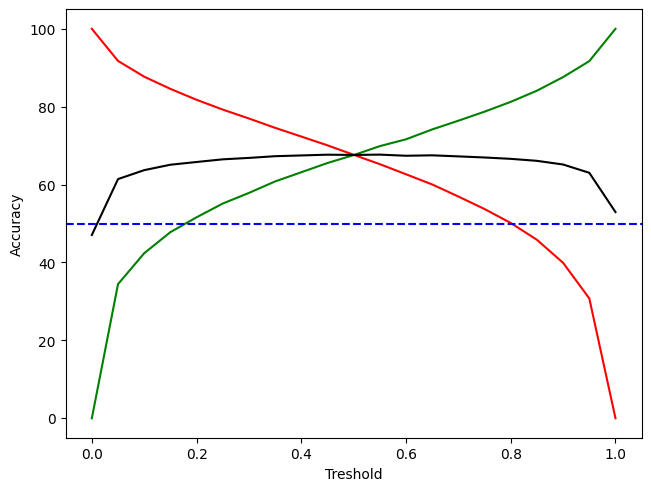

In [19]:
printAccuracyAtAllThresholds(vitH14_accuracies_laion_stable)

In [8]:
vitL14_accuracies_datacomp_fuse = pandas.read_csv("data/fuse/progan+stable_vitL14_200k_datacomp_net_accuracy.csv", header=0, index_col=0)
vitH14_accuracies_laion_fuse = pandas.read_csv("data/fuse/progan+stable_vitH14_200k_laion_net_accuracy.csv", header=0, index_col=0)
vitL14_accuracies_openai_fuse = pandas.read_csv("data/fuse/progan+stable_vitL14_200k_openai_net_accuracy.csv", header=0, index_col=0)

0.00  :  0.47058823529411764    0.0
0.05  :  0.6979617070520793    0.5057948175442722
0.10  :  0.7243036606739456    0.5757564739182078
0.15  :  0.7398920572789808    0.6208512909491157
0.20  :  0.7513273722932168    0.6553295285823687
0.25  :  0.7589119143031503    0.6817369682045177
0.30  :  0.7657561803228832    0.7058553219895098
0.35  :  0.7710683753877013    0.7249833658114908
0.40  :  0.7772758204821285    0.7485764334693137
0.45  :  0.7827716916673967    0.7703010090700646
0.50  :  0.7876364369495455    0.791581375186987
0.55  :  0.7913868704896744    0.81140939783317
0.60  :  0.7939667283950119    0.8318478551223855
0.65  :  0.7972043741538156    0.8562749041415431
0.70  :  0.7998984560388377    0.8834981924341065
0.75  :  0.802708060538485    0.9138121512517908
0.80  :  0.8042647163809816    0.9503711865660588
0.85  :  0.8062522688874509    0.9942073004696349
0.90  :  0.8071974108561442    1.0555226707753758
0.95  :  0.8065856098776482    1.170792957754735
1.00  :  0.53063618

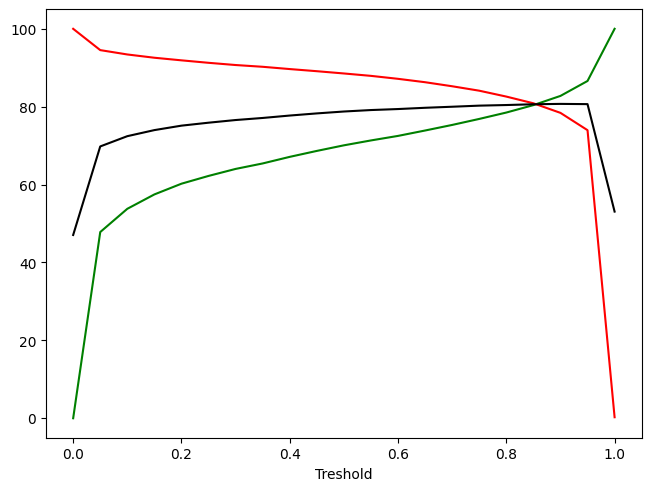

In [9]:
printAccuracyAtAllThresholds(vitH14_accuracies_laion_fuse)

0.00  :  0.47058823529411764    0.0
0.05  :  0.7295785626204198    0.6565029041066276
0.10  :  0.7646122784307716    0.796163710248862
0.15  :  0.7827179813862757    0.8857230943206683
0.20  :  0.7935360160232405    0.9534408686594916
0.25  :  0.7992154743886121    1.0097712165087058
0.30  :  0.8044335602162154    1.0602571502129785
0.35  :  0.8070100401052528    1.1030734332868983
0.40  :  0.8093129587429563    1.147060834253299
0.45  :  0.8089718562928843    1.1887403635282068
0.50  :  0.8087608971343149    1.2279161785851687
0.55  :  0.8068669420257466    1.2705142932455162
0.60  :  0.8040215074574963    1.315108143714784
0.65  :  0.8011618611360366    1.3643750397270626
0.70  :  0.8002479413908048    1.420914750850618
0.75  :  0.7963484806417631    1.4847161638844941
0.80  :  0.7902008519874907    1.559240067096256
0.85  :  0.7829385008825915    1.6536847580913798
0.90  :  0.7701511137781732    1.7897517554938973
0.95  :  0.7487681717859523    2.0418255962178464
1.00  :  0.52941764

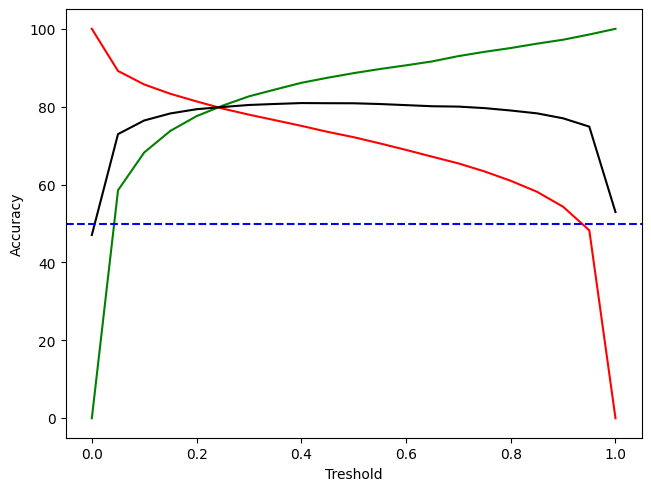

In [7]:
printAccuracyAtAllThresholds(vitL14_accuracies_openai_fuse)

0.00  :  0.47058823529411764    0.0
0.05  :  0.6788820770091142    0.4637527583640209
0.10  :  0.7065328134759553    0.5371855898813539
0.15  :  0.7245396967473066    0.5882050379685543
0.20  :  0.7360823682936334    0.6224537337062293
0.25  :  0.7462004965276569    0.6541138035535583
0.30  :  0.7547776873176706    0.6824131332332123
0.35  :  0.7615379610207246    0.7072916305512931
0.40  :  0.768230485136858    0.7323686848013692
0.45  :  0.7745325577018366    0.757302503236787
0.50  :  0.779538467149091    0.7827472783433221
0.55  :  0.7836388106644939    0.8047544702110426
0.60  :  0.7874078935379395    0.8307642994958411
0.65  :  0.7915249408132777    0.8563678698610685
0.70  :  0.7943816521257537    0.8840227030165868
0.75  :  0.7969623525747259    0.9213951481313584
0.80  :  0.7992338143367368    0.9619131512606329
0.85  :  0.8020294068359908    1.0141309562153178
0.90  :  0.8030224440386523    1.0869697080615646
0.95  :  0.7993016183957906    1.2150301868660758
1.00  :  0.529535

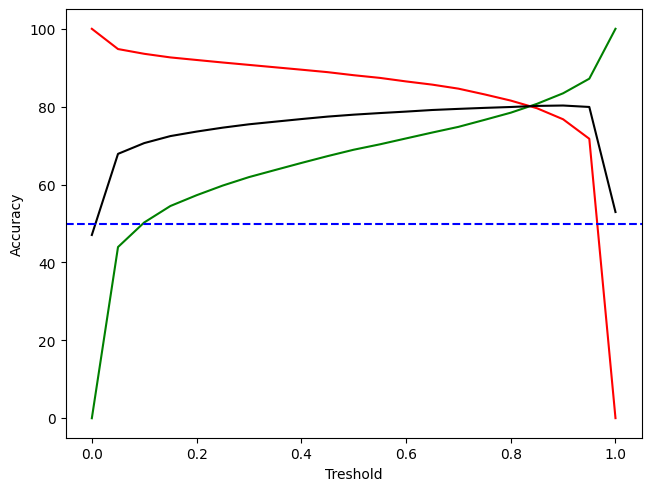

In [8]:
printAccuracyAtAllThresholds(vitH14_accuracies_laion_fuse)

In [6]:
vitL14_progan_openai = pandas.read_csv("data/progan-trained/vitL14_progan_openai+BLIP_100k_net_accuracies.csv", header=0, index_col=0)
vitH14_progan_laion = pandas.read_csv("data/progan-trained/vitH14_progan_laion+BLIP_100k_net_accuracies.csv", header=0, index_col=0)
vitL14_stable_datacomp = pandas.read_csv("data/stable-trained/vitL14_stable_100k_openai+BLIP_net_accuracies.csv", header=0, index_col=0)
vitL14_stable_openai = pandas.read_csv("data/stable-trained/vitL14_stable_100k_openai+BLIP_net_accuracies.csv", header=0, index_col=0)

0.00  :  0.47058823529411764    0.0
0.05  :  0.7731626563228365    0.7914683080582093
0.10  :  0.8082471082343471    0.9495286460262776
0.15  :  0.8228292753599247    1.0455601607854705
0.20  :  0.830967112423746    1.1188331282326787
0.25  :  0.8351204274369037    1.173323599869971
0.30  :  0.8369449733299984    1.221452037331949
0.35  :  0.8360571508894098    1.2641236363722914
0.40  :  0.8338934416474748    1.308821056197133
0.45  :  0.8322521279399852    1.3542537855245196
0.50  :  0.8293742627145821    1.3953896694470516
0.55  :  0.8252847548119506    1.4412268700737232
0.60  :  0.8211898172575953    1.484712056255812
0.65  :  0.8155330084983294    1.5345789021672727
0.70  :  0.8095665178507734    1.5873058923952916
0.75  :  0.8031974907251648    1.6415179151221508
0.80  :  0.7942901965675757    1.7142751978098667
0.85  :  0.7832315994701554    1.8115841296606412
0.90  :  0.7679403155831772    1.9406877732332857
0.95  :  0.7446795613463483    2.168565039426918
1.00  :  0.529570588

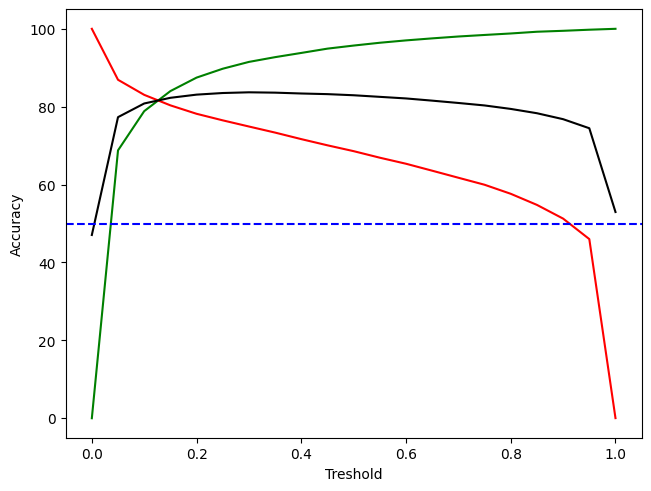

In [7]:
printAccuracyAtAllThresholds(vitL14_progan_openai)

0.00  :  0.47058823529411764    0.0
0.05  :  0.7670868850602761    0.7696896977418795
0.10  :  0.7918037502847534    0.9022246374542401
0.15  :  0.8016500651496996    0.9908984858027561
0.20  :  0.8078198240327872    1.0615605035274782
0.25  :  0.810725478088524    1.1226249834639657
0.30  :  0.8120257228347264    1.1765467688607822
0.35  :  0.8107636454721528    1.226089162426884
0.40  :  0.8093229481856877    1.2721518477230482
0.45  :  0.8061861998725267    1.3209348659740467
0.50  :  0.8038641038831561    1.3679358733208213
0.55  :  0.8002873235912561    1.4192033726172917
0.60  :  0.7960914552624567    1.4750487432502515
0.65  :  0.7923939329840048    1.5293886611757097
0.70  :  0.7862328097883422    1.592202984982509
0.75  :  0.780195708993404    1.661174245380281
0.80  :  0.773302558193443    1.7481351365592126
0.85  :  0.7627685266080091    1.860934985657078
0.90  :  0.7483504113897134    2.034342641304217
0.95  :  0.7248937216040985    2.3231431307234423
1.00  :  0.53201757661

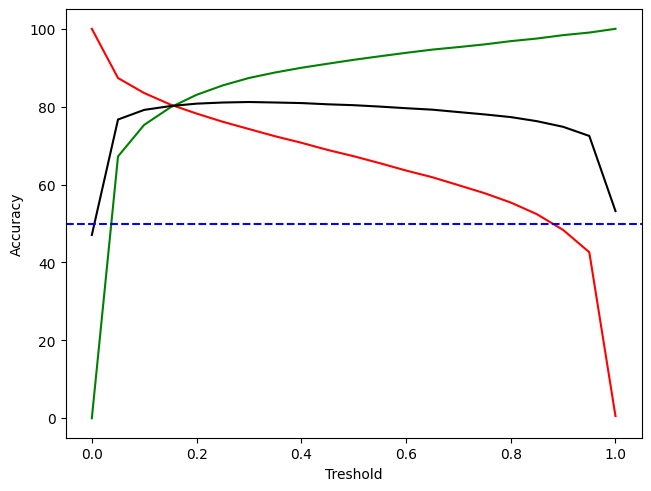

In [8]:
printAccuracyAtAllThresholds(vitH14_progan_laion)

In [5]:
progan_openai_model1 = pandas.read_csv("data/progan-trained/vitL14_progan_openai_720k_net_accuracies.csv", header=0, index_col=0)
progan_openai_model2 = pandas.read_csv("data/ablation/progan_openai_model2.csv", header=0, index_col=0)
progan_openai_model3 = pandas.read_csv("data/ablation/progan_openai_model3.csv", header=0, index_col=0)
progan_openai_blip_model1 = pandas.read_csv("data/progan-trained/vitL14_progan_openai+BLIP_100k_net_accuracies.csv", header=0, index_col=0)
progan_openai_blip_model2 = pandas.read_csv("data/ablation/progan_openai+BLIP_model2.csv", header=0, index_col=0)
progan_openai_blip_model3 = pandas.read_csv("data/ablation/progan_openai+BLIP_model3.csv", header=0, index_col=0)
progan_stable_laion_model1 = pandas.read_csv("data/fuse/progan+stable_vitH14_200k_laion_net_accuracy.csv", header=0, index_col=0)
progan_stable_laion_model2 = pandas.read_csv("data/ablation/progan+stable_laion_model2.csv", header=0, index_col=0)
progan_stable_laion_model3 = pandas.read_csv("data/ablation/progan+stable_laion_model3.csv", header=0, index_col=0)

0.00  :  0.47058823529411764    0.0
0.05  :  0.7731626563228365    0.7914683080582093
0.10  :  0.8082471082343471    0.9495286460262776
0.15  :  0.8228292753599247    1.0455601607854705
0.20  :  0.830967112423746    1.1188331282326787
0.25  :  0.8351204274369037    1.173323599869971
0.30  :  0.8369449733299984    1.221452037331949
0.35  :  0.8360571508894098    1.2641236363722914
0.40  :  0.8338934416474748    1.308821056197133
0.45  :  0.8322521279399852    1.3542537855245196
0.50  :  0.8293742627145821    1.3953896694470516
0.55  :  0.8252847548119506    1.4412268700737232
0.60  :  0.8211898172575953    1.484712056255812
0.65  :  0.8155330084983294    1.5345789021672727
0.70  :  0.8095665178507734    1.5873058923952916
0.75  :  0.8031974907251648    1.6415179151221508
0.80  :  0.7942901965675757    1.7142751978098667
0.85  :  0.7832315994701554    1.8115841296606412
0.90  :  0.7679403155831772    1.9406877732332857
0.95  :  0.7446795613463483    2.168565039426918
1.00  :  0.529570588

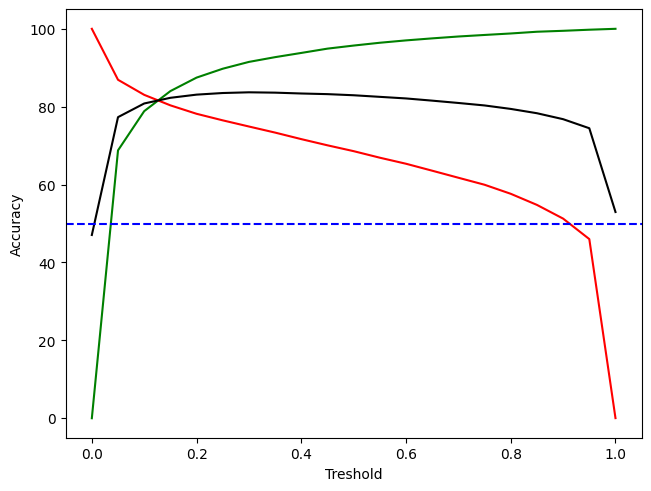

In [16]:
printAccuracyAtAllThresholds(progan_openai_blip_model1)

In [52]:
progan_openai_RC = pandas.read_csv("data/compressed/progan_openai.csv", header=0, index_col=0)
progan_laion_RC = pandas.read_csv("data/compressed/progan_laion.csv", header=0, index_col=0)
stable_openai_RC = pandas.read_csv("data/compressed/stable_openai.csv", header=0, index_col=0)
stable_laion_RC = pandas.read_csv("data/compressed/stable_laion.csv", header=0, index_col=0)
fused_openai_RC = pandas.read_csv("data/compressed/fused_openai.csv", header=0, index_col=0)
fused_laion_RC = pandas.read_csv("data/compressed/fused_laion.csv", header=0, index_col=0)

progan_openai = pandas.read_csv("data/progan-trained/vitL14_progan_openai_720k_net_accuracies.csv", header=0, index_col=0)
progan_laion = pandas.read_csv("data/progan-trained/vitH14_progan_laion_100k_net_accuracies.csv", header=0, index_col=0)
stable_openai = pandas.read_csv("data/stable-trained/vitL14_stable_100k_openai_net_accuracies.csv", header=0, index_col=0)
stable_laion = pandas.read_csv("data/stable-trained/vitH14_stable_100k_laion_net_accuracies.csv", header=0, index_col=0)
fused_openai = pandas.read_csv("data/fuse/progan+stable_vitL14_200k_openai_net_accuracy.csv", header=0, index_col=0)
fused_laion = pandas.read_csv("data/fuse/progan+stable_vitH14_200k_laion_net_accuracy.csv", header=0, index_col=0)

0.00  :  0.47058823529411764    0.0
0.05  :  0.6979617070520793    0.5057948175442722
0.10  :  0.7243036606739456    0.5757564739182078
0.15  :  0.7398920572789808    0.6208512909491157
0.20  :  0.7513273722932168    0.6553295285823687
0.25  :  0.7589119143031503    0.6817369682045177
0.30  :  0.7657561803228832    0.7058553219895098
0.35  :  0.7710683753877013    0.7249833658114908
0.40  :  0.7772758204821285    0.7485764334693137
0.45  :  0.7827716916673967    0.7703010090700646
0.50  :  0.7876364369495455    0.791581375186987
0.55  :  0.7913868704896744    0.81140939783317
0.60  :  0.7939667283950119    0.8318478551223855
0.65  :  0.7972043741538156    0.8562749041415431
0.70  :  0.7998984560388377    0.8834981924341065
0.75  :  0.802708060538485    0.9138121512517908
0.80  :  0.8042647163809816    0.9503711865660588
0.85  :  0.8062522688874509    0.9942073004696349
0.90  :  0.8071974108561442    1.0555226707753758
0.95  :  0.8065856098776482    1.170792957754735
1.00  :  0.53063618

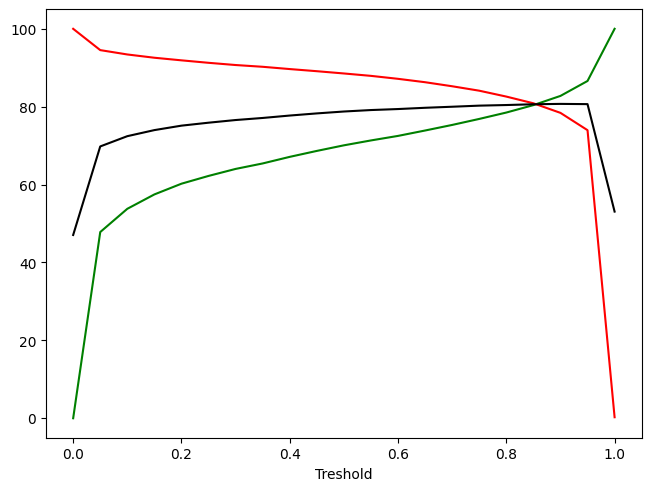

In [65]:
printAccuracyAtAllThresholds(fused_laion)

In [11]:
vitH14_fused_laion = pandas.read_csv("data/fuse/progan+stable_vitH14_200k_laion+BLIP_net_accuracy.csv", header=0, index_col=0)
vitH14_fused_laion_clip = pandas.read_csv("data/fuse/progan+stable_vitH14_200k_laion_net_accuracy.csv", header=0, index_col=0)

0.00  :  0.47058823529411764    0.0
0.05  :  0.6757800258791299    0.4608734388668174
0.10  :  0.7033231641695069    0.5344274641112482
0.15  :  0.7213003315816277    0.5845197787307086
0.20  :  0.7353238628547177    0.6245245323904133
0.25  :  0.7449984104435246    0.6552549086797773
0.30  :  0.7515660183349457    0.6819746005451979
0.35  :  0.7580764449858198    0.7073609447066161
0.40  :  0.7636400405708783    0.7302555681939654
0.45  :  0.7685408985751959    0.7537706611522721
0.50  :  0.7739119606862954    0.7769728581751646
0.55  :  0.7777668965432194    0.7991573584264287
0.60  :  0.7819303511409244    0.8244666136145917
0.65  :  0.7856393570661568    0.8517899357884015
0.70  :  0.7892514395363524    0.88116670451754
0.75  :  0.792453868557679    0.9148782611740719
0.80  :  0.7949499274971624    0.9546570169279351
0.85  :  0.797801160005797    1.007618185586953
0.90  :  0.7969669738580596    1.081310669653559
0.95  :  0.7934186477959867    1.2071653949595937
1.00  :  0.529565686

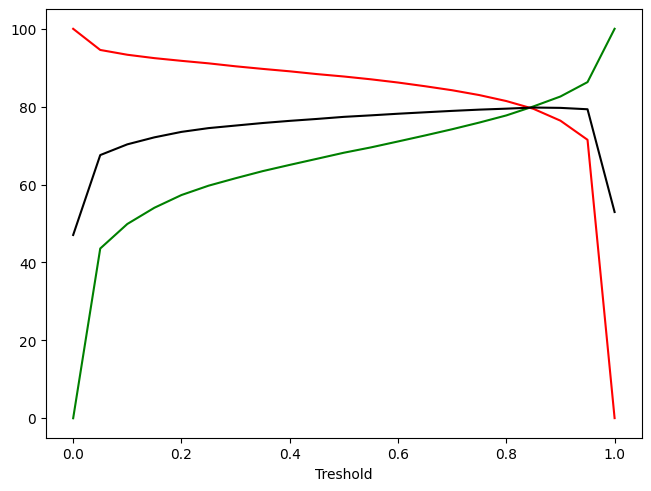

In [12]:
printAccuracyAtAllThresholds(vitH14_fused_laion)